https://github.com/abojchevski/rsc

http://sci-hub.tw/10.1145/3097983.3098156

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import k_means


class RSC:
    """
    Implementation of the method proposed in the paper:
    'Robust Spectral Clustering for Noisy Data: Modeling Sparse Corruptions Improves Latent Embeddings'

    If you publish material based on algorithms or evaluation measures obtained from this code,
    then please note this in your acknowledgments and please cite the following paper:
        Aleksandar Bojchevski, Yves Matkovic, and Stephan Günnemann.
        2017. Robust Spectral Clustering for Noisy Data.
        In Proceedings of KDD’17, August 13–17, 2017, Halifax, NS, Canada.

    Copyright (C) 2017
    Aleksandar Bojchevski
    Yves Matkovic
    Stephan Günnemann
    Technical University of Munich, Germany
    """

    def __init__(self, k, nn=15, theta=20, m=0.5, laplacian=1, n_iter=50, normalize=False, verbose=False):
        """
        :param k: number of clusters
        :param nn: number of neighbours to consider for constructing the KNN graph (excluding the node itself)
        :param theta: number of corrupted edges to remove
        :param m: minimum percentage of neighbours to keep per node (omega_i constraints)
        :param n_iter: number of iterations of the alternating optimization procedure
        :param laplacian: which graph Laplacian to use: 0: L, 1: L_rw, 2: L_sym
        :param normalize: whether to row normalize the eigen vectors before performing k-means
        :param verbose: verbosity
        """

        self.k = k
        self.nn = nn
        self.theta = theta
        self.m = m
        self.n_iter = n_iter
        self.normalize = normalize
        self.verbose = verbose
        self.laplacian = laplacian

        if laplacian == 0:
            if self.verbose:
                print('Using unnormalized Laplacian L')
        elif laplacian == 1:
            if self.verbose:
                print('Using random walk based normalized Laplacian L_rw')
        elif laplacian == 2:
            raise NotImplementedError('The symmetric normalized Laplacian L_sym is not implemented yet.')
        else:
            raise ValueError('Choice of graph Laplacian not valid. Please use 0, 1 or 2.')

    def __latent_decomposition(self, X):
        # compute the KNN graph
        A = kneighbors_graph(X=X, n_neighbors=self.nn, metric='euclidean', include_self=False, mode='connectivity')
        A = A.maximum(A.T)  # make the graph undirected

        N = A.shape[0]  # number of nodes
        deg = A.sum(0).A1  # node degrees

        prev_trace = np.inf  # keep track of the trace for convergence
        Ag = A.copy()

        for it in range(self.n_iter):

            # form the unnormalized Laplacian
            D = sp.diags(Ag.sum(0).A1).tocsc()
            L = D - Ag

            # solve the normal eigenvalue problem
            if self.laplacian == 0:
                h, H = eigsh(L, self.k, which='SM')
            # solve the generalized eigenvalue problem
            elif self.laplacian == 1:
                h, H = eigsh(L, self.k, D, which='SM')

            trace = h.sum()

            if self.verbose:
                print('Iter: {} Trace: {:.4f}'.format(it, trace))

            if self.theta == 0:
                # no edges are removed
                Ac = sp.coo_matrix((N, N), [np.int])
                break

            if prev_trace - trace < 1e-10:
                # we have converged
                break

            allowed_to_remove_per_node = (deg * self.m).astype(np.int)
            prev_trace = trace

            # consider only the edges on the lower triangular part since we are symmetric
            edges = sp.tril(A).nonzero()
            removed_edges = []

            if self.laplacian == 1:
                # fix for potential numerical instability of the eigenvalues computation
                h[np.isclose(h, 0)] = 0

                # equation (5) in the paper
                p = np.linalg.norm(H[edges[0]] - H[edges[1]], axis=1) ** 2 \
                    - np.linalg.norm(H[edges[0]] * np.sqrt(h), axis=1) ** 2 \
                    - np.linalg.norm(H[edges[1]] * np.sqrt(h), axis=1) ** 2
            else:
                # equation (4) in the paper
                p = np.linalg.norm(H[edges[0]] - H[edges[1]], axis=1) ** 2

            # greedly remove the worst edges
            for ind in p.argsort()[::-1]:
                e_i, e_j, p_e = edges[0][ind], edges[1][ind], p[ind]

                # remove the edge if it satisfies the constraints
                if allowed_to_remove_per_node[e_i] > 0 and allowed_to_remove_per_node[e_j] > 0 and p_e > 0:
                    allowed_to_remove_per_node[e_i] -= 1
                    allowed_to_remove_per_node[e_j] -= 1
                    removed_edges.append((e_i, e_j))
                    if len(removed_edges) == self.theta:
                        break

            removed_edges = np.array(removed_edges)
            Ac = sp.coo_matrix((np.ones(len(removed_edges)), (removed_edges[:, 0], removed_edges[:, 1])), shape=(N, N))
            Ac = Ac.maximum(Ac.T)
            Ag = A - Ac

        return Ag, Ac, H

    def fit_predict(self, X):
        """
        :param X: array-like or sparse matrix, shape (n_samples, n_features)
        :return: cluster labels ndarray, shape (n_samples,)
        """

        Ag, Ac, H = self.__latent_decomposition(X)
        self.Ag = Ag
        self.Ac = Ac

        if self.normalize:
            self.H = H / np.linalg.norm(H, axis=1)[:, None]
        else:
            self.H = H

        centroids, labels, *_ = k_means(X=self.H, n_clusters=self.k)

        self.centroids = centroids
        self.labels = labels

        return labels

In [2]:

from sklearn.cluster import SpectralClustering
from sklearn import datasets
from sklearn.metrics import normalized_mutual_info_score as nmi


import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Ground truth clusters')

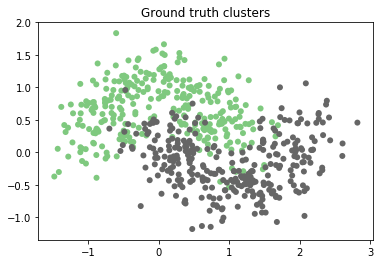

In [31]:
X, y = datasets.make_moons(600, shuffle=False, random_state=4, noise=0.3)
k = y.max()+1
nn = 15
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', linewidths=0)
plt.title('Ground truth clusters')

In [32]:

rsc = RSC(k=k, nn=nn, theta=10, verbose=True)
y_rsc = rsc.fit_predict(X)

sc = SpectralClustering(n_clusters=k, n_neighbors=nn+1, affinity='nearest_neighbors')  # nn+1 since they include self
y_sc = sc.fit_predict(X)

print(f'Vanilla Spectral Clustering NMI: {nmi(y, y_sc)}\n Robust Spectral Clustering NMI: {nmi(y, y_rsc)}')

Using random walk based normalized Laplacian L_rw
Iter: 0 Trace: 0.0061
Iter: 1 Trace: 0.0055
Iter: 2 Trace: 0.0054
Iter: 3 Trace: 0.0054
Iter: 4 Trace: 0.0054
Vanilla Spectral Clustering NMI: 0.2608825489699251
 Robust Spectral Clustering NMI: 0.2723487932453046


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


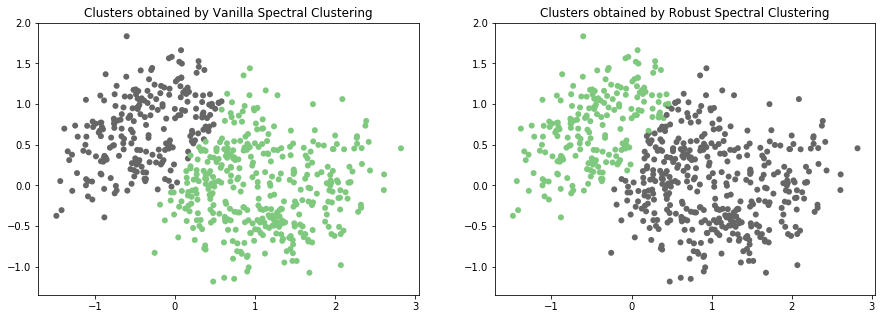

In [33]:
fig, ax = plt.subplots(1, 2, figsize=[15, 5])
ax[0].scatter(X[:, 0], X[:, 1], c=y_sc, cmap='Accent', linewidths=0)
ax[0].set_title('Clusters obtained by Vanilla Spectral Clustering')

ax[1].scatter(X[:, 0], X[:, 1], c=y_rsc, cmap='Accent', linewidths=0)
ax[1].set_title('Clusters obtained by Robust Spectral Clustering');

(300, 2)


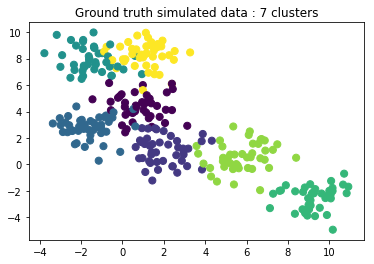

In [26]:
k = 7
nn=10
X, y_true = datasets.make_blobs(n_samples=300, centers=k,
                       cluster_std=.95, random_state=0)
/print X.shape
plt.title(f'Ground truth simulated data : {k} clusters')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_true);

In [27]:
rsc = RSC(k=k, nn=nn, theta=10, verbose=True)
y_rsc = rsc.fit_predict(X)

sc = SpectralClustering(n_clusters=k, n_neighbors=nn+1, affinity='nearest_neighbors')  # nn+1 since they include self
y_sc = sc.fit_predict(X)

print(f'Vanilla Spectral Clustering NMI: {nmi(y_true, y_sc)}\n Robust Spectral Clustering NMI: {nmi(y_true, y_rsc)}')

Using random walk based normalized Laplacian L_rw
Iter: 0 Trace: 0.1587
Iter: 1 Trace: 0.1378
Iter: 2 Trace: 0.1360
Iter: 3 Trace: 0.1360
Vanilla Spectral Clustering NMI: 0.8231601050835993
 Robust Spectral Clustering NMI: 0.8170398142408698


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
